In [158]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
import random
import joblib

In [104]:
df = pd.read_csv('data/train.csv')

 | __variable__   | __Description__ |
 | :--            | -:-             |
 | ` current_asst_liability_ratio `  | current asset/ (total asset - total equity) 
 | ` current_ratio_st `| Current Ratio = current asset / current liabilities (short term debt + accounts payable)
 | ` intangible_asst_ratio `      | intangible asset / total asset bad
 | ` current_asst_ratio `       | current asset / total asset good
 | ` cash_liability_ratio `     | cash ratio = cash / current liabilities
 | ` capital_employed `     | Capital employed=Total assets−Current liabilities
 | ` capital_turnover_ratio `       | (Capital Turnover Ratio Formula = Operating Revenue - COGS (Cost of Goods Sold) / Capital Employed
 |`ROCE`    |ROCE=EBIT/ Capital employed
 | ` logit_total_asset `      | log(total asset) (a measure of company scale)
 | ` debt_service_ratio `        | Debt service coverage ratio = ebitda/current debt
 | ` interest_coverage_ratio `       | interest coverage ratio = ebitda/interest_expenses
 | ` leverage  ` | leverage = total liabilities/ total Equity
 | ` extraord_ratio `        | extraord_ratio=inc_extraord / rev_operations
 | ` finance_rev_ratio `        | finance_rev_ratio=Financial income / rev_operations
 | ` roa `   | roa = net_profit / total asset 
 | ` roe `    | roe = net_profit / equity
 | ` equity_asst_ratio `  |equity_asst_ratio= equity/total assets
 | ` cash_asst_ratio ` | cash_asst_ratio =cash flow/total asset

### Helping function

In [105]:
# split_dataset
def random_split(df, train_proportion):
    id_lst = df['id'].unique().tolist()
    random.shuffle(id_lst)
    train_id = id_lst[:int(len(id_lst)*train_proportion)]
    test_id = id_lst[int(len(id_lst)*train_proportion):]
    return df[df['id'].isin(train_id)], df[df['id'].isin(test_id)]

# Normalization/ Binorization / Standardization
def winsorize_feature(feature, limit=[0.02, 0.02]):
    return mstats.winsorize(feature, limit)

# visuallization function
def plot_distribution(df, col,num=20):
    df['binned_'+col] = pd.qcut(df[col], num,duplicates='drop')
    df[['binned_'+col, 'defaulted']].groupby('binned_'+col).mean().reset_index().sort_values('binned_'+col).set_index('binned_'+col).plot.bar()

### Target: if the (def_date- stmt_date)<= 12 months, we take it as 1, otherwise 0.

In [106]:
# create default variable
def defaulted(ser):
    if pd.isnull(ser['def_date']) or (ser['def_date'] - ser['stmt_date']).days > 365:
        return 0 
    else:
        return 1

df['stmt_date'] = pd.to_datetime(df['stmt_date'])
df['def_date'] = pd.to_datetime(df['def_date'])
df['defaulted'] = df.apply(defaulted,axis=1)

### feature engineer

### Qiwen Zhang

##### 1. current_asst_liability_ratio: The ratio between current asset and total liability. current asset liability ratio=current asset/ (total asset - total equity)

#### This feature is an indicator of a company's current asset compared to its total liability.

In [107]:
df['current_asst_liability_ratio'] = df['asst_current']/(df['asst_tot']-df['eqty_tot'])

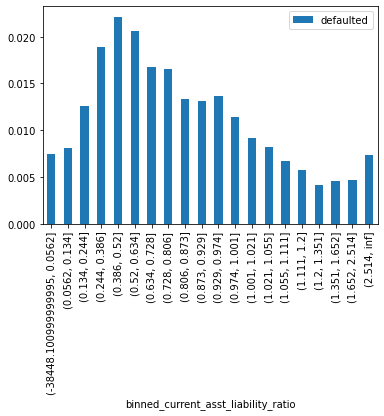

In [108]:
plot_distribution(df,'current_asst_liability_ratio')

#### Insights: Beyond a certain threshold, companies with high current asset liability ratio are less likely to default.

#### 2. current_ratio_st: the ratio between current asset and short term liability. Current Ratio = current asset / current liabilities (short term bank debt + short term financial debt+ short term other debt + short term accounts payable)

#### This feature is similar to the feature above but looks at only the ratio between asset and short term liabilities.

In [109]:
df['current_ratio_st'] = df['asst_current']/(df['debt_bank_st'] + df['debt_fin_st'] + df['AP_st'] + df['debt_st'])

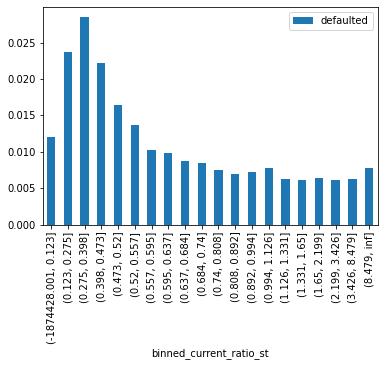

In [110]:
plot_distribution(df,'current_ratio_st')

#### Similar trend was observed that beyond a certain threshold, companies with high current ratio are less likely to default.

#### 3.intangible_asst_ratio: ratio between intangible asset and total asset. Intangible asset ratio = intangible asset / total asset.

#### An intangible asset is an asset that is not physical in nature. Goodwill, brand recognition and intellectual property. Hence if the ratio between intangible asset and total asset is high, this means the company is less stable financially and more likely to default.

In [111]:
df['intangible_asst_ratio'] = df['asst_intang_fixed']/df['asst_tot']

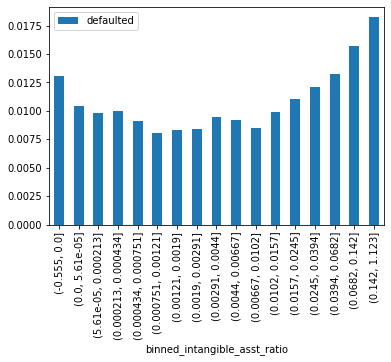

In [112]:
plot_distribution(df,'intangible_asst_ratio')

#### We can see that companies with higher intangible asset ratio is more likely to default.

#### 4.current_asst_ratio: ratio between current asset and total asset. Current asset ratio = current asset / total asset.¶


#### Current Assets is an account listed on a balance sheet that shows the value of the assets owned by a company that can be converted to cash. If a company's current asset ratio is high, the company is less likely to default.

In [113]:
df['current_asst_ratio'] = df['asst_current']/df['asst_tot']

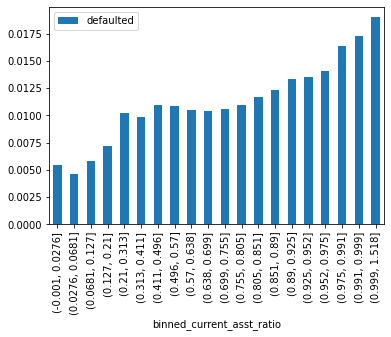

In [114]:
plot_distribution(df,'current_asst_ratio')

#### 5.cash_liability_ratio: Ratio between amount of operating cash flow and short term liability. Cash liability ratio = cf_operations / short term liability(short term bank debt + short term financial debt+ short term other debt + short term accounts payable)

#### Companies with high cash_liability ratio should be less likely to default.

In [115]:
df['cash_liability_ratio'] = df['cf_operations']/(df['debt_bank_st'] + df['debt_fin_st'] + df['AP_st'] + df['debt_st'])

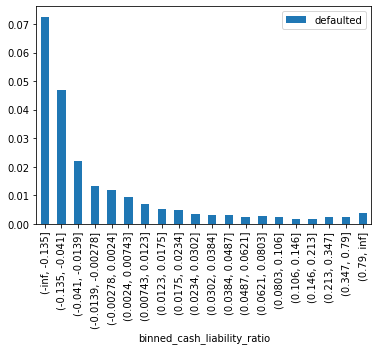

In [116]:
plot_distribution(df,'cash_liability_ratio')

In [117]:
inf_clr=df[df['cash_liability_ratio'] == float('-inf')][['cash_liability_ratio','cf_operations','debt_bank_st','debt_fin_st','AP_st','debt_st','defaulted']]

In [118]:
inf_clr

,cash_liability_ratio,cf_operations,debt_bank_st,debt_fin_st,AP_st,debt_st,defaulted
2373,-inf,-24547.0,0.0,0.0,0.0,0.0,0
8125,-inf,-512074.0,0.0,0.0,0.0,0.0,0
14359,-inf,-10148.0,0.0,0.0,0.0,0.0,0
14360,-inf,-6725.0,0.0,0.0,0.0,0.0,0
16138,-inf,-34044.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
1021170,-inf,-2728.0,0.0,0.0,0.0,0.0,0
1022128,-inf,-227644.0,0.0,0.0,0.0,0.0,0
1022344,-inf,-3888.0,0.0,0.0,0.0,0.0,0
1023148,-inf,-510.0,0.0,0.0,0.0,0.0,0


In [119]:
inf_clr.defaulted.value_counts()

0    811
1     26
Name: defaulted, dtype: int64

In [120]:
26/837

0.03106332138590203

###### From the above we can see that cash_liability_ratio has many nagative infnite values, and for these companies, their do not have short-term liabilities. For these companies their defaulted possibilities are about 0.031

### Shiqi Yang

##### 6. capital_employed : The total amount of capital used for the acquisition of profits by a firm or project. Capital employed=Total assets−Current liabilities 

##### Capital employed can give a snapshot of how a company is investing its money. From the given trainset, we already have capital_employed and suppose Current liabilities=debt_bank_st+debt_fin_st+ AP_st +debt_st (Short term financial obligation)

In [121]:
df['capital_employed'] = df['asst_tot'] - (df['debt_bank_st'] + df['debt_fin_st'] + df['AP_st'] + df['debt_st'])

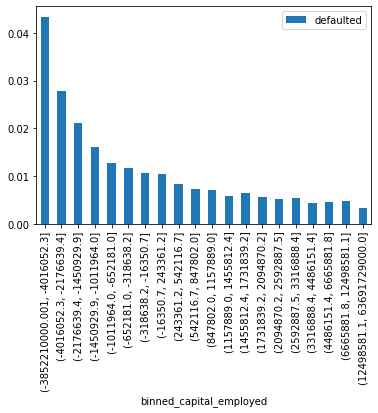

In [122]:
plot_distribution(df,'capital_employed')

#### it seems company with  higher capital employed has less probability to default. This is because higher capital employed means the company has rich funds and active business.

##### 7. capital turnover ratio:indicates the efficiency of the organization with which the capital employed is being utilized.  capital turnover ratio=net sales/ capital_employed

In [123]:
df['capital_turnover_ratio'] = (df['rev_operating']-df['COGS'])/df['capital_employed']

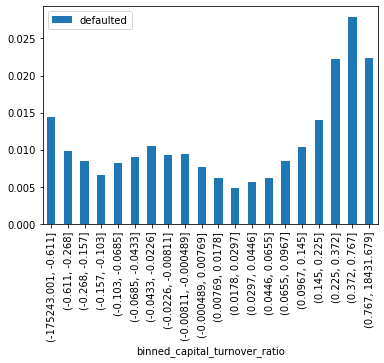

In [124]:
plot_distribution(df,'capital_turnover_ratio')

##### 8.ROCE is a metric for analyzing profitability and for comparing profitability levels across companies in terms of capital. ROCE=EBIT/ Capital employed

##### Here we use the ebitda(Earnings before interest, taxes, depreciation, and amortization) which is also simiar to EBIT(earning before interest and tax)

In [125]:
df['ROCE'] = df['ebitda']/df['capital_employed']

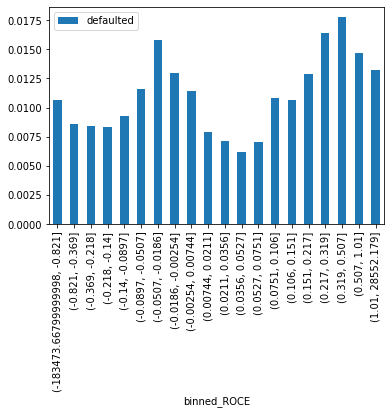

In [126]:
plot_distribution(df,'ROCE')

##### 9. log(total asset) : The size of campany 

In [127]:
df['log_total_asset']=np.log(df['asst_tot'])

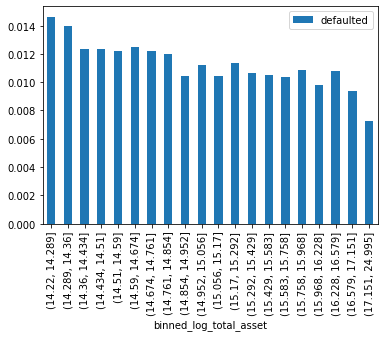

In [128]:
plot_distribution(df,'log_total_asset')

##### We can see for big company(with large asset) they have higher ability to resist risk and therefore lower possibility to default.

##### 10.The debt service coverage ratio(DSCR) is one of the important solvency ratios and helps the analyst determine if the firm generates sufficient net operating income to service its debt repayment. The ratio states net operating income as a multiple of debt obligations due within one year.

##### debt_coverage_ratio= ebit/current debt.  Here we have current debt=debt_st

In [129]:
df['debt_coverage_ratio'] = (df['ebitda'])/(df['debt_st'])

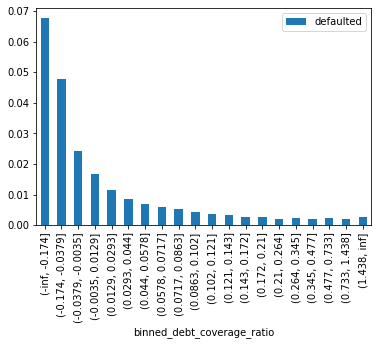

In [130]:
plot_distribution(df,'debt_coverage_ratio')

##### We can see companies with low debt_coverage_ratio has more probability to default

Evaluating DSCR Outcomes

Lenders will routinely assess a borrower's DSCR before making a loan. A DSCR of less than 1 means negative cash flow, which means that the borrower will be unable to cover or pay current debt obligations without drawing on outside sources—in essence, borrowing more.

A DSCR of at least 2 is considered very strong. Many lenders will set minimum DSCR requirements between 1.2 and 1.25.

##### 11.Leverage: total liabilities/total equity

In [131]:
df['leverage'] = (df['asst_tot'] - df['eqty_tot']) / df['eqty_tot']

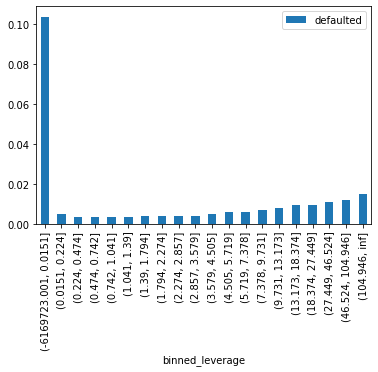

In [132]:
plot_distribution(df,'leverage')

* Negative leverage is a scenario where the addition of debt in a commercial real estate transaction causes the levered return to be less than the unleveraged return.
* Negative leverage occurs when the borrowing costs are greater than the overall return produced by the property’s cash flow.
* The risks of using negative leverage include lower overall returns as well as more serious consequences if the property’s cash flow cannot keep up with the required mortgage payments.

##### 12.The interest coverage ratio measures a company's ability to handle its outstanding debt. It is one of a number of debt ratios that can be used to evaluate a company's financial condition. interest_coverage_ratio= ebitda/ interest_expense

##### Here we use financial_expense similar to interest_expense

In [133]:
df['interest_coverage_ratio']=df['ebitda']/df['exp_financing']

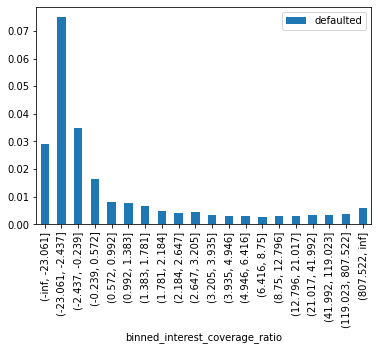

In [134]:
plot_distribution(df,'interest_coverage_ratio')

#### we can see if the interest_coverage_ratio is low(negative), the company has a much higher probabilty to default 

If a company has a low-interest coverage ratio, there's a greater chance the company won't be able to service its debt, putting it at risk of bankruptcy. In other words, a low-interest coverage ratio means there is a low amount of profits available to meet the interest expense on the debt. Also, if the company has variable-rate debt, the interest expense will rise in a rising interest rate environment. 

A high ratio indicates there are enough profits available to service the debt. But it may also mean the company is not using its debt properly. For example, if a company is not borrowing enough, it may not be investing in new products and technologies to stay ahead of the competition in the long term. 

* An interest coverage ratio of at least 2 is generally considered the minimum acceptable amount for a company that has solid, consistent revenues.

* Analysts prefer to see a coverage ratio of 3 or better.
* A coverage ratio below 1  indicates a company cannot meet its current interest payment obligations and, therefore, is not in good financial health.

### Ashely

### 13.Extraordiary Income Ratio
- Extraordiary Income / Operating Revenue
- It's the ratio that measures the percentage of extradordinary income in the entire operating revenue
- This ratio incidates the amount of operating revenue that is unusual and infrequent. In other words, these are transactions that are abnormal and don't relate to the principle business activities. 
- With higher Extraordiary Income Ratio, the operating revenue will be less robust and more unpredictable

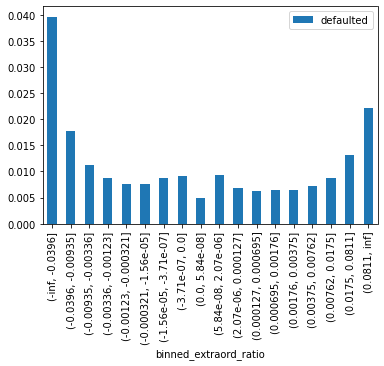

In [135]:
df['extraord_ratio'] = df['inc_extraord']/ df['rev_operating']
plot_distribution(df,'extraord_ratio')

### 14.Financial Revenue Ratio
- Financial Income / Operating Revenue
- It's the ratio that measures the percentage of the revenue generated by the temporary surplus cash invested in short-term investments and Marketable securities. 
- A high Financial Revenue Ratio indicates the company has a good financial performance and a healthy cash flow

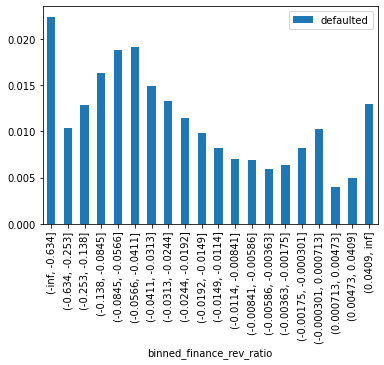

In [136]:
df['finance_rev_ratio'] = df['inc_financing']/df['rev_operating']
plot_distribution(df,'finance_rev_ratio')

In [137]:
inf_frr=df.loc[df['finance_rev_ratio']==-float('inf')][['finance_rev_ratio','inc_financing','rev_operating','defaulted']]

In [138]:
inf_frr

,finance_rev_ratio,inc_financing,rev_operating,defaulted
177,-inf,-122.0,0.0,0
586,-inf,-10735.0,0.0,0
829,-inf,-1085176.0,0.0,0
831,-inf,-123569.0,0.0,0
1104,-inf,-1439.0,0.0,0
...,...,...,...,...
1023363,-inf,-6823.0,0.0,0
1023394,-inf,-43560.0,0.0,0
1023395,-inf,-215.0,0.0,0
1023430,-inf,-235.0,0.0,0


In [139]:
inf_frr.rev_operating.value_counts()

0.0    16567
Name: rev_operating, dtype: int64

In [140]:
inf_frr.defaulted.value_counts()

0    16257
1      310
Name: defaulted, dtype: int64

In [141]:
310/16567

0.018711897144926663

##### From the above we can see many company's financial  revenue ratio = -inf , this is because they all have 0 operating revenue. Their default possibility =0.018711897144926663

### 15.Return on Assets
- Net Profit / Total Asset
- It's the ratio that incidates how profitable a company is in relation to its total assets
- A higher ROA means that a company uses the assets it owns to generate profits efficiently

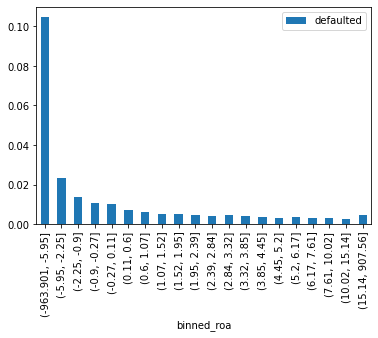

In [142]:
plot_distribution(df,'roa')

### 16. Return on Equity
- Net Profit / Equity (`profit` / `eqty_tot`)
- It's the measure of a company's net income divided by its shareholders' equity
- The higher the ROE, the better a company is at converting its equity financing into profits.

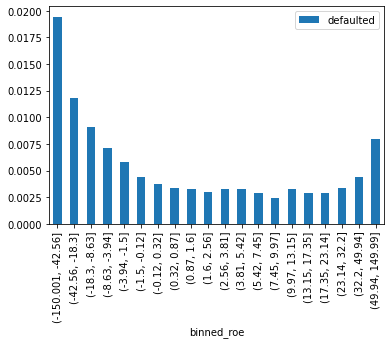

In [143]:
plot_distribution(df,'roe')

### 17.Equity-To-Asset Ratio
- Total Equity / Total Asset
- It's a measure of a company's financial leverage calculated by dividing its equity by its total assets. 
- It indicates the percentage of total assets that is financed by shareholders' equity. 
- A high equity to asset ratio means that a company is more likely to be able to pay back its debtors.

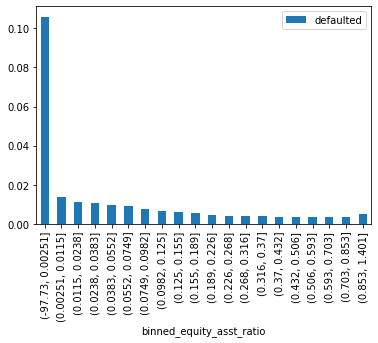

In [144]:
df['equity_asst_ratio'] = df['eqty_tot']/df['asst_tot']
plot_distribution(df,'equity_asst_ratio')

### 18.Cash Flow-To-Asset Ratio
- Cash Flow / Total Asset
- It indicates a company's ability to generate cash compared to its asset size. 
- A ratio of 0.30 (30%) is quite good. When the ratio declines below 10% then there may be some cause for concern.

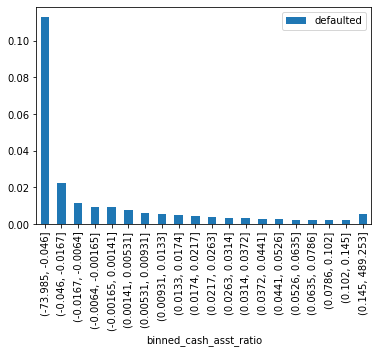

In [145]:
df['cash_asst_ratio'] = df['cf_operations']/df['asst_tot']
plot_distribution(df,'cash_asst_ratio')

In [146]:
#df.to_csv('../data/with_added_feature.csv')

### Train_test_split

In [147]:
# random test split
def random_split(df, train_proportion):
    id_lst = df['id'].unique().tolist()
    random.shuffle(id_lst)
    train_id = id_lst[:int(len(id_lst)*train_proportion)]
    test_id = id_lst[int(len(id_lst)*train_proportion):]
    return df[df['id'].isin(train_id)], df[df['id'].isin(test_id)]

# Random Forest model

### remove irrelavent columns

## preprocess

In [148]:
def preprocessing(df):
    new_df = df.iloc[:,39:].drop(columns = ['wc_net','margin_fin','cf_operations'])
    cols = []
    for col in new_df.columns:
        if 'binned' in col:
            cols.append(col)
    new_df = new_df.drop(columns = cols)
    new_df['id']=df['id']
    
    train_y = new_df['defaulted']
    train_X = new_df.drop(columns=['defaulted'])
    for col in train_X.columns:
        if col!= 'id':
            train_X[col] = pd.Series(winsorize(train_X[col],limits=[0.2,0.2],nan_policy='omit'))    
            train_X[col] = train_X[col].fillna(train_X[col].mean())

    return train_X, train_y

In [149]:
def random_split(df, train_proportion):
    id_lst = df['id'].unique().tolist()
    random.shuffle(id_lst)
    train_id = id_lst[:int(len(id_lst)*train_proportion)]
    test_id = id_lst[int(len(id_lst)*train_proportion):]
    return df[df['id'].isin(train_id)], df[df['id'].isin(test_id)]

In [150]:
X,y=preprocessing(df)

In [151]:
y

0          0
1          0
2          0
3          0
4          0
          ..
1023547    0
1023548    0
1023549    0
1023550    0
1023551    0
Name: defaulted, Length: 1023552, dtype: int64

### cross_ validation 

In [152]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE


In [153]:
clf={'n_estimators':100,
    #'criterion':'gini',
    #'max_depth':20,
    #'min_samples_split':2,
    #'min_samples_leaf':1,
    #'max_leaf_nodes':10,
     #'bootstrap':True,
    }

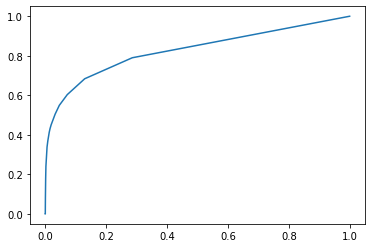

In [164]:
    skf = StratifiedKFold(n_splits=5)
    id_lst=pd.Series(X['id'].unique().tolist())
    rfs=RandomForestClassifier(**clf)
    res={'acc':[],'fprs':[],'tprs':[],'threds':[],'auc':[], 'f1':[]}
    for train_index, test_index in skf.split(id_lst, df.groupby('id').sum()['defaulted'].loc[id_lst]):
        train_id=id_lst.loc[train_index]
        test_id=id_lst.loc[test_index]
        train_X=X[X['id'].isin(train_id)]
        test_X=X[X['id'].isin(test_id)]
        train_y=y.loc[train_X.index]
        test_y=y.loc[test_X.index]
#         sm = SMOTE()
#         train_X, train_y = sm.fit_resample(train_X, train_y)
        rfs.fit(train_X.drop(columns=['id']),train_y)
        pred = rfs.predict_proba(test_X.drop(columns=['id']))[:,1]
        acc=accuracy_score(test_y,(pred>0.5).astype(int))
        f1 = f1_score(test_y,(pred>0.5).astype(int))
        fpr,tpr,thred=roc_curve(test_y,pred)
        auc=roc_auc_score(test_y,pred)
        res['acc'].append(acc)
        res['fprs'].append(fpr)
        res['tprs'].append(tpr)
        res['threds'].append(thred)
        res['auc'].append(auc)
        res['f1'].append(f1)
        plt.plot(fpr,tpr)
        plt.show()
        break

In [183]:
plt.rcParams["figure.figsize"] = (20,10)
font = {'family' : 'normal',
        'size'   : 22}
plt.rc('font', **font)

<AxesSubplot:>

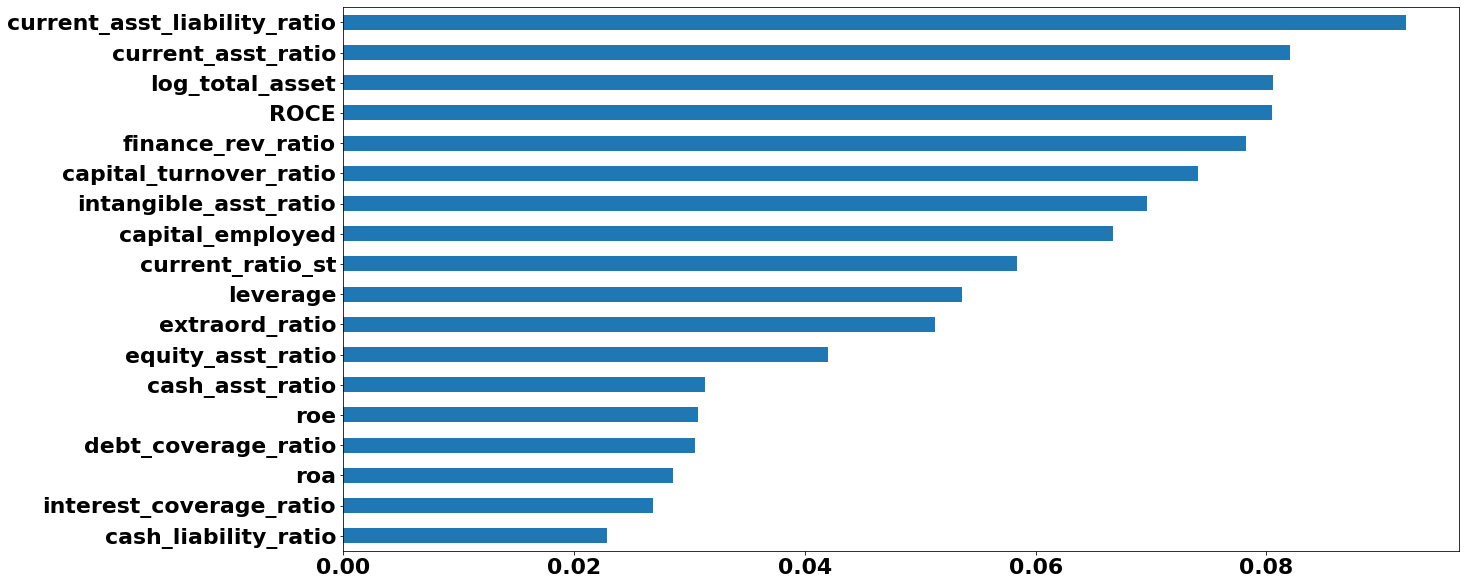

In [184]:
pd.Series(rfs.feature_importances_, index = rfs.feature_names_in_).sort_values().plot(kind='barh')

In [168]:
rfs.feature_names_in_

array(['roa', 'roe', 'current_asst_liability_ratio', 'current_ratio_st',
       'intangible_asst_ratio', 'current_asst_ratio',
       'cash_liability_ratio', 'capital_employed',
       'capital_turnover_ratio', 'ROCE', 'log_total_asset',
       'debt_coverage_ratio', 'leverage', 'interest_coverage_ratio',
       'extraord_ratio', 'finance_rev_ratio', 'equity_asst_ratio',
       'cash_asst_ratio'], dtype=object)

In [154]:
def kfold_train(X ,y, clf,nsplit=5):
    skf = StratifiedKFold(n_splits=5)
    id_lst=pd.Series(X['id'].unique().tolist())
    rfs=RandomForestClassifier(**clf)
    res={'acc':[],'fprs':[],'tprs':[],'threds':[],'auc':[], 'f1':[]}
    for train_index, test_index in skf.split(id_lst, df.groupby('id').sum()['defaulted'].loc[id_lst]):
        train_id=id_lst.loc[train_index]
        test_id=id_lst.loc[test_index]
        train_X=X[X['id'].isin(train_id)]
        test_X=X[X['id'].isin(test_id)]
        train_y=y.loc[train_X.index]
        test_y=y.loc[test_X.index]
#         sm = SMOTE()
#         train_X, train_y = sm.fit_resample(train_X, train_y)
        rfs.fit(train_X.drop(columns=['id']),train_y)
        pred = rfs.predict_proba(test_X.drop(columns=['id']))[:,1]
        acc=accuracy_score(test_y,(pred>0.5).astype(int))
        f1 = f1_score(test_y,(pred>0.5).astype(int))
        fpr,tpr,thred=roc_curve(test_y,pred)
        auc=roc_auc_score(test_y,pred)
        res['acc'].append(acc)
        res['fprs'].append(fpr)
        res['tprs'].append(tpr)
        res['threds'].append(thred)
        res['auc'].append(auc)
        res['f1'].append(f1)
        plt.plot(fpr,tpr)
        plt.show()
    return res,rfs

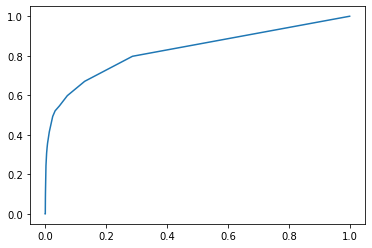

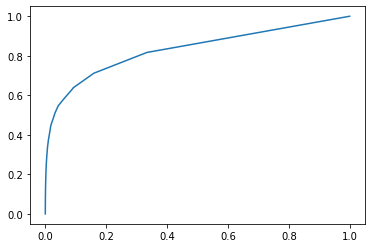

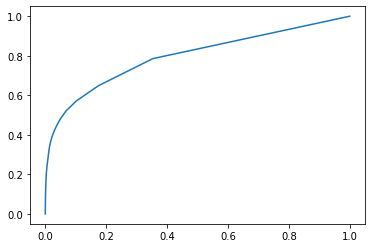

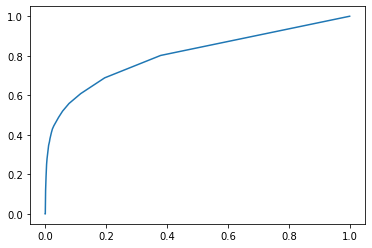

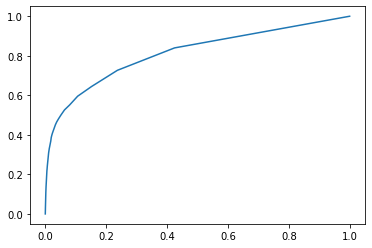

In [155]:
output_params, rfs_model=kfold_train(X,y,clf,5)

In [156]:
output_params

{'acc': [0.9905317892158976,
  0.9896513955508555,
  0.988813127002139,
  0.9889839056700339,
  0.9864038486194806],
 'fprs': [array([0.00000000e+00, 4.35485065e-06, 4.35485065e-06, 4.35485065e-06,
         4.35485065e-06, 4.35485065e-06, 8.70970130e-06, 8.70970130e-06,
         1.74194026e-05, 2.17742533e-05, 3.48388052e-05, 4.79033572e-05,
         4.79033572e-05, 5.66130585e-05, 6.96776104e-05, 7.83873117e-05,
         8.27421624e-05, 8.27421624e-05, 9.14518637e-05, 9.14518637e-05,
         1.08871266e-04, 1.21935818e-04, 1.48064922e-04, 1.74194026e-04,
         1.95968279e-04, 2.17742533e-04, 2.35161935e-04, 2.74355591e-04,
         3.09194396e-04, 3.22258948e-04, 3.39678351e-04, 3.39678351e-04,
         3.74517156e-04, 3.96291409e-04, 4.26775364e-04, 4.61614169e-04,
         5.05162675e-04, 5.53066033e-04, 5.66130585e-04, 6.14033942e-04,
         6.66292150e-04, 7.05485805e-04, 7.49034312e-04, 7.79518266e-04,
         7.79518266e-04, 8.27421624e-04, 8.70970130e-04, 8.70970130e-04,

In [167]:
joblib.dump(rfs, "model/rfs_model.joblib")

['model/rfs_model.joblib']

In [162]:
rfs

RandomForestClassifier()

In [163]:
rfs.feature_importances_

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.